In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer
from explainers_lib.model import Model as ExplainerModel
import explainers_lib.model
from explainers_lib.datasets import Dataset

from explainers_lib.explainers.native.wachter import WachterExplainer
from explainers_lib.explainers.native.face import FaceExplainer as NativeFaceExplainer
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer

from explainers_lib.explainers.celery_explainer import ActionableRecourseExplainer
from explainers_lib.explainers.native.face import FaceExplainer
from explainers_lib.explainers.dice.dice import DiceExplainer
from explainers_lib.explainers.celery_explainer import AlibiCFProto
from explainers_lib.explainers.celery_explainer import AlibiCFRLMNIST

from explainers_lib.aggregators import Pareto, All
from explainers_lib.datasets import Dataset
from explainers_lib.ensemble import Ensemble


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_val_ds = MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = MNIST(root='./data', train=False, download=True, transform=transform)

train_ds, val_ds = train_test_split(train_val_ds, test_size=0.1, shuffle=True, random_state=42)

train_dl = DataLoader(train_ds, batch_size=10000, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)


In [4]:
class_map = {i: str(i) for i in range(10)}


In [5]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class TransConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(1, 64),   # 32 -> 16
            ConvBlock(64, 128),  # 16 -> 8
            ConvBlock(128, 256), # 8 -> 4
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, latent_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            TransConvBlock(256, 128),   # 4 -> 8
            TransConvBlock(128, 64),    # 8 -> 16
            TransConvBlock(64, 32),     # 16 -> 32
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = Encoder(latent_dim).to(device)
        self.decoder = Decoder(latent_dim).to(device)

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        flatten_dim = 64 * 8 * 8

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [7]:
import torch
import torch.nn as nn

class LatentToClassPipeline(nn.Module):
    def __init__(self, decoder, cnn):
        super().__init__()
        self.decoder = decoder
        self.cnn = cnn

    def forward(self, x):
        # 1. Decode
        decoded = self.decoder(x)
        # 2. Classify
        logits = self.cnn(decoded)
        return logits


In [8]:
import torch

autoencoder = Autoencoder(latent_dim=32).to(device)

weights = torch.load("models/torch_ae_mnist_paper.pth", map_location=device)

autoencoder.load_state_dict(weights)

autoencoder.eval()


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ConvBlock(
        (block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): Flatten(start_dim=1, end_dim=-1)
      (4): Linear(in

In [9]:
cnn = CNN().to(device)
cnn_weights = torch.load("models/torch_cnn_mnist_paper.pth", map_location=device)
cnn.load_state_dict(cnn_weights)
cnn.eval()


CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [10]:
from explainers_lib.model import TorchModel


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

n_samples = 10000

images_batch, labels_batch = next(iter(train_dl))
imgs = images_batch[:n_samples].to(device)
targets = labels_batch[:n_samples].cpu().tolist()

with torch.no_grad():
    latent_tensors = autoencoder.encoder(imgs)

latent_instance_np = latent_tensors.cpu().detach().numpy()
latent_dim_actual = latent_instance_np.shape[1]
feature_names = [f'l{i}' for i in range(latent_dim_actual)]

data_df = pd.DataFrame(latent_instance_np, columns=feature_names)

identity = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', feature_names)
    ], remainder='drop')
identity.fit(data_df)

latent_dataset_train = Dataset(
    df=data_df,
    target=targets,
    features=feature_names,
    categorical_features=[],
    continuous_features=feature_names,
    immutable_features=[],
    allowable_ranges={},
    preprocessor=identity
)


In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

n_samples = 2

images_batch, labels_batch = next(iter(test_dl))
imgs = images_batch[:n_samples].to(device)
targets = labels_batch[:n_samples].cpu().tolist()

with torch.no_grad():
    latent_tensors = autoencoder.encoder(imgs)

latent_instance_np = latent_tensors.cpu().detach().numpy()
latent_dim_actual = latent_instance_np.shape[1]
feature_names = [f'l{i}' for i in range(latent_dim_actual)]

data_df = pd.DataFrame(latent_instance_np, columns=feature_names)

identity = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', feature_names)
    ], remainder='drop')

identity.fit(data_df)

latent_dataset = Dataset(
    df=data_df,
    target=targets,
    features=feature_names,
    categorical_features=[],
    continuous_features=feature_names,
    immutable_features=[],
    allowable_ranges={},
    preprocessor=identity
)


In [43]:
pipeline = LatentToClassPipeline(autoencoder.decoder, cnn).to(device)
pipeline = pipeline.to("cpu")
pipeline.eval()

scripted_model = torch.jit.script(pipeline)
scripted_model.to(device).eval()

new_torch_model = TorchModel(scripted_model)

ensemble = Ensemble(
    new_torch_model,
    [
        # Native
        # WachterExplainer(lambda_param=500),
        # GrowingSpheresExplainer(step_size=0.001, num_samples=200, max_radius=5),
        # NativeFaceExplainer(),
        # # # Carla
        # # # TODO(patryk): currently broken, but I am working on it! 
        # # ActionableRecourseExplainer(),
        # # # Dice
        # DiceExplainer(num_cfs=2,method="random"),
        # Alibi
        # AlibiCFProto(),
        AlibiCFRLMNIST()    
    ],
    All()
 )

ensemble.fit(latent_dataset_train)
print("Ensemble fitted.")
cfes = ensemble.explain(latent_dataset)


Ensemble fitted.


In [44]:
cfes


[Counterfactual(original_data=array([-0.40026417,  0.2840871 , -0.25426182, -0.08256465, -0.3379517 ,
         0.06049024, -0.32979217, -0.09350673, -0.09910263, -0.49455142,
         0.14938922,  0.28022656, -0.40321234, -0.20988573, -0.04941612,
        -0.16505283,  0.01361746, -0.4437384 ,  0.613273  ,  0.23644571,
        -0.07276378,  0.2612393 , -0.043307  ,  0.22681813,  0.10325653,
         0.30885178,  0.36942473,  0.2663113 , -0.07226785, -0.3972664 ,
         0.35795298, -0.29349962], dtype=float32), data=array([ 0.40699765, -0.37362796, -0.60422003,  0.26757243,  0.1036071 ,
        -0.371917  , -0.65064204, -0.49349228,  0.5759251 ,  0.1543625 ,
         0.580009  , -0.24559717, -0.16637613,  0.33648694,  0.43034747,
         0.44174626,  0.26644403,  0.3138109 , -0.24771827,  0.33285072,
        -0.16367239, -0.07168757, -0.47670767, -0.19658586, -0.29087022,
         0.49219316, -0.39263418, -0.41163236,  0.54610765, -0.1861912 ,
        -0.03635822,  0.5068887 ], dtype

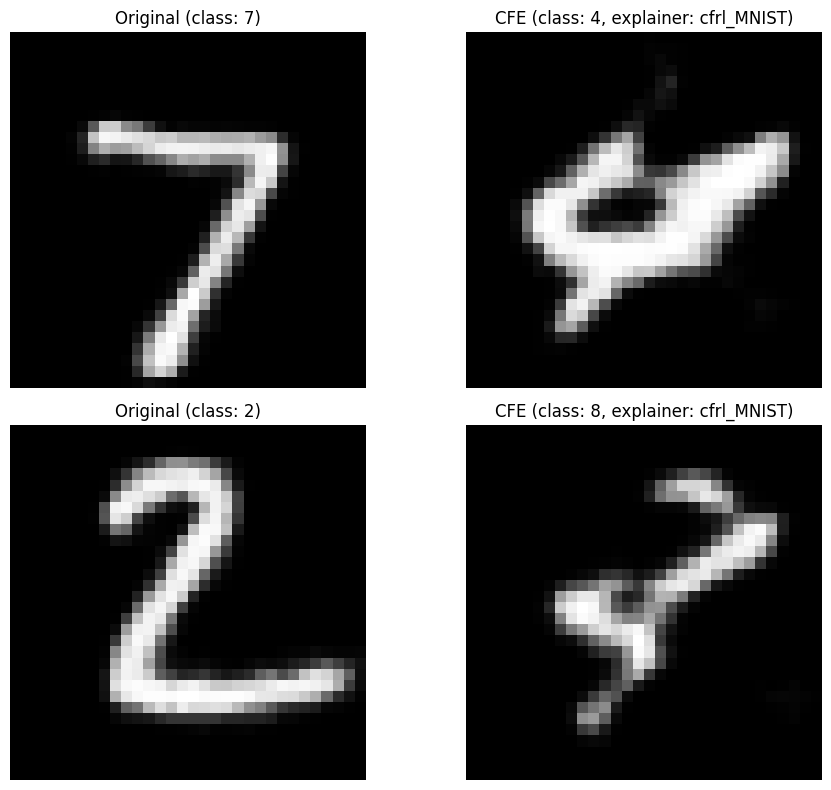

In [45]:
def plot_cfes(cfes):
    n = len(cfes)
    plt.figure(figsize=(10, 4 * n))
    autoencoder.to(device)
    autoencoder.eval()

    for i in range(n):
        cf = cfes[i]

        # ---- ORIGINAL RECONSTRUCTION ----
        org_latent = torch.tensor(cf.original_data, dtype=torch.float32, device=device).unsqueeze(0)
        org_recon = autoencoder.decoder(org_latent)

        org_recon_np = org_recon.detach().cpu().numpy()[0, 0] # Select batch and channel
        org_recon_np = (org_recon_np + 1) / 2
        org_recon_np = org_recon_np.clip(0, 1)

        # ---- COUNTERFACTUAL RECONSTRUCTION ----
        cf_latent = torch.tensor(cf.data, dtype=torch.float32, device=device).unsqueeze(0)
        cfe_recon = autoencoder.decoder(cf_latent)

        cfe_recon_np = cfe_recon.detach().cpu().numpy()[0, 0] # Select batch and channel
        cfe_recon_np = (cfe_recon_np + 1) / 2
        cfe_recon_np = cfe_recon_np.clip(0, 1)

        # ---- PLOTTING ----
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(org_recon_np, cmap='gray')
        plt.title(f"Original (class: {class_map[cf.original_class]})")
        plt.axis("off")

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(cfe_recon_np, cmap='gray')
        plt.title(f"CFE (class: {class_map[cf.target_class]}, explainer: {cf.explainer[:10]})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
plot_cfes(cfes)


In [46]:
from explainers_lib.aggregators import Pareto, BalancedPoint, DensityBased, IdealPoint, TOPSIS

pareto = Pareto()
balancedPoint = BalancedPoint()
densityBased = DensityBased()
idealPoint = IdealPoint()
topsis = TOPSIS(k=3)

pareto.fit(new_torch_model, latent_dataset_train)
balancedPoint.fit(new_torch_model, latent_dataset_train)
topsis.fit(new_torch_model, latent_dataset_train)
idealPoint.fit(new_torch_model, latent_dataset_train)


In [47]:
pareto_cfes = pareto(cfes)
balancedPoint_cfes = balancedPoint(cfes)
densityBased_cfes = densityBased(cfes)
idealPoint_cfes = idealPoint(cfes)
topsis_cfes = topsis(cfes)


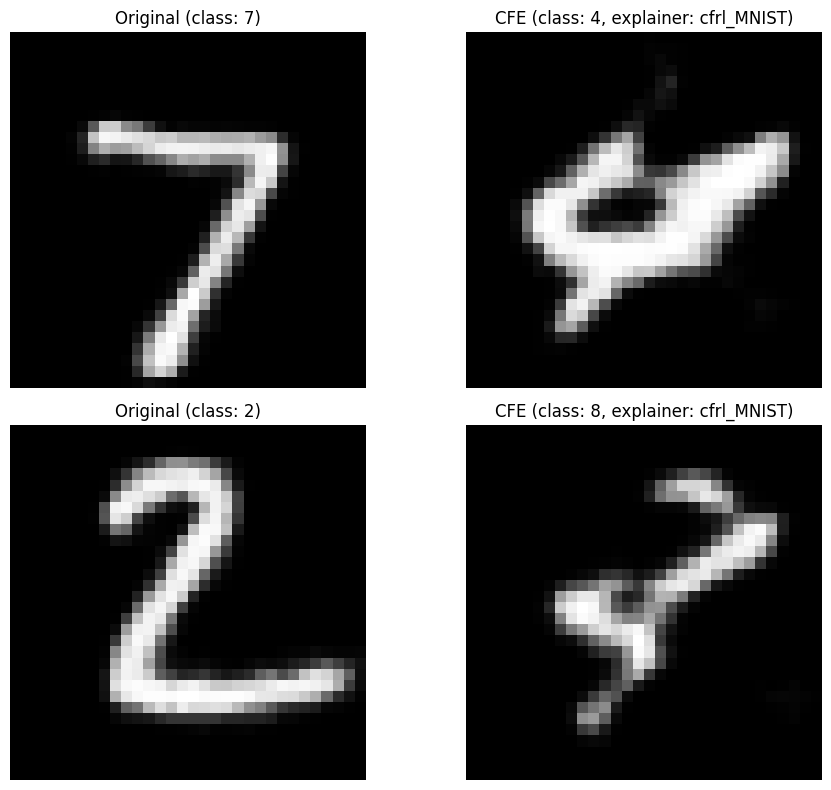

In [48]:
plot_cfes(pareto_cfes)


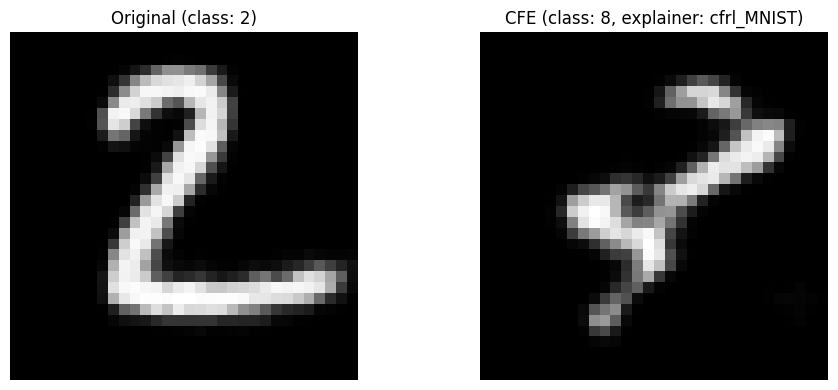

In [49]:
plot_cfes(balancedPoint_cfes)


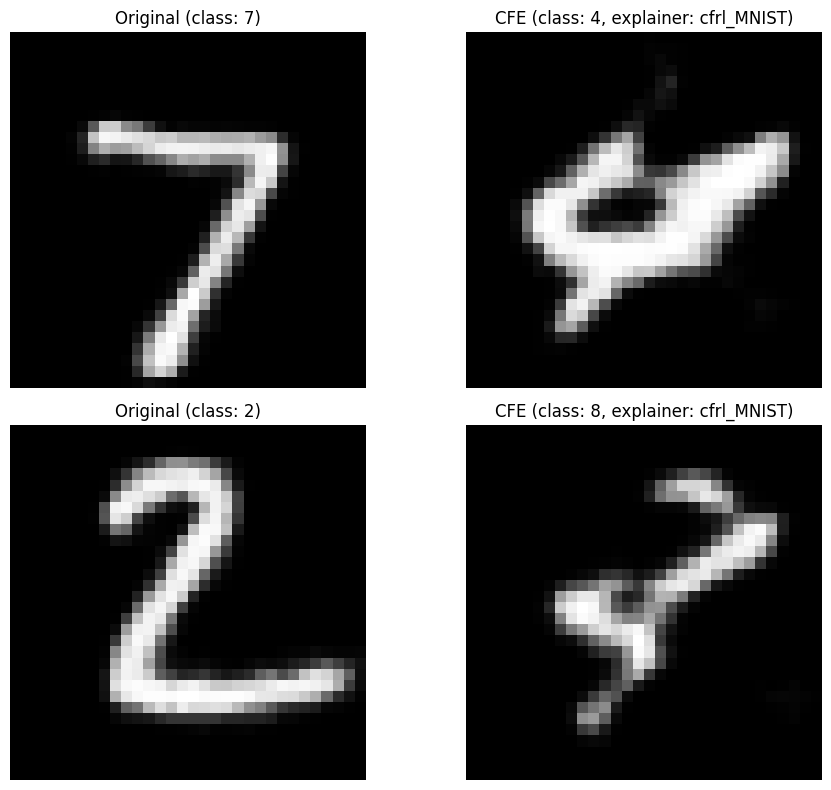

In [50]:
plot_cfes(densityBased_cfes)


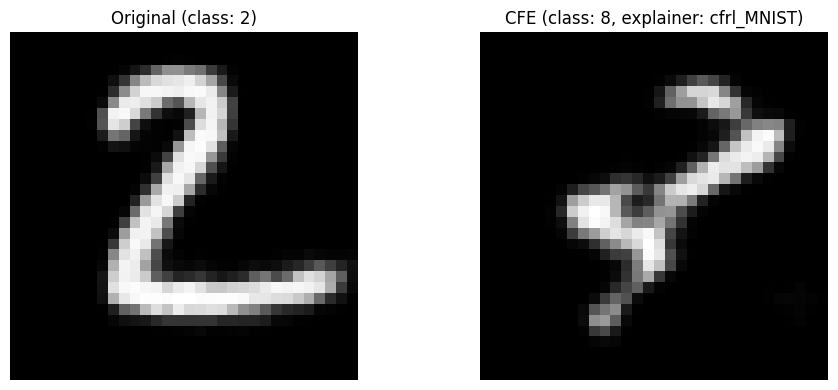

In [51]:
plot_cfes(idealPoint_cfes)


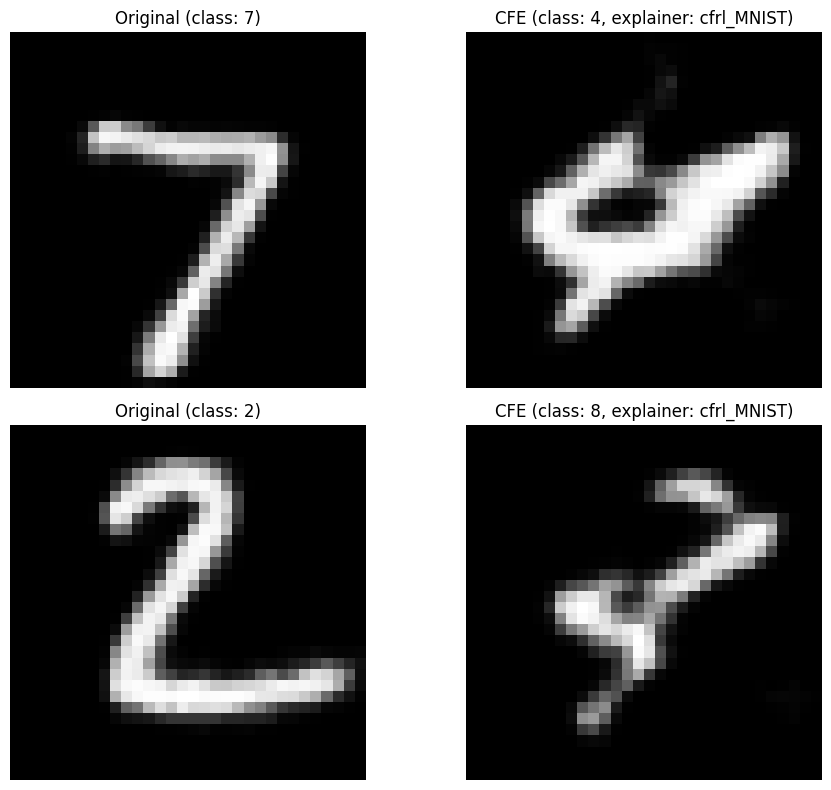

In [52]:
plot_cfes(topsis_cfes)


In [53]:
from pickle import dump

dump(cfes, open("results/mnist_ensemble_explainer.pkl", "wb"))
